## Import libreries

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from scipy.stats import ttest_ind, f_oneway


## Loading dataset

In [50]:
# Load dataset
url = "https://raw.githubusercontent.com/DickySaragih/Ml_Terapan/refs/heads/main/Data_siswa.csv"
df = pd.read_csv(url)


In [51]:
# Tampilkan struktur awal dataset
print("\nInformasi Dataset:")
df.info()
print("\nStatistik Deskriptif:")
print(df.describe())


Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB

Statistik Deskriptif:
       math score  reading score  writing score
count  1000.00000    1000.000000    1000.000000
mean     66.08900      69.169000      68.054000
std      15.16308      14.600192      15.195657
min       0.00000      17.000000      1

#### Insight:

- Proses *loading* dataset diawali dengan membaca data dari URL yang disediakan menggunakan fungsi `pd.read_csv()`.  Data yang dibaca kemudian disimpan ke dalam variabel `siswa_df` sebagai objek DataFrame di Pandas. Selanjutnya,  informasi struktur data ditampilkan menggunakan `siswa_df.info()` yang memberikan detail mengenai tipe data setiap kolom dan jumlah data yang tidak kosong.  Kemudian,  statistika deskriptif ditampilkan dengan `siswa_df.describe()` untuk memberikan gambaran ringkas mengenai distribusi data numerik, termasuk mean, standar deviasi, nilai minimum, maksimum, dan kuartil. Langkah-langkah ini penting untuk memahami struktur dan karakteristik data sebelum dilakukan analisis lebih lanjut, termasuk identifikasi potensi *missing value* dan *outlier*.



### Cleaning data

In [52]:
# Data Cleaning
print("\nJumlah Nilai Hilang per Kolom:")
print(df.isnull().sum())

numerical_cols = df.select_dtypes(include=np.number).columns
imputer = SimpleImputer(strategy='mean')
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

# mengecek duplikat pada data
print("\nJumlah Data Duplikat:", df.duplicated().sum())

# Mengahpus duplikat
df.drop_duplicates(inplace=True)

# mengecek tipe data
print("\nTipe Data Setelah Pembersihan:")
print(df.dtypes)

# menampilkan hasil pembersihan pada dat
print("\nInformasi Dataset Setelah Pembersihan:")
df.info()



Jumlah Nilai Hilang per Kolom:
gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

Jumlah Data Duplikat: 0

Tipe Data Setelah Pembersihan:
gender                          object
race/ethnicity                  object
parental level of education     object
lunch                           object
test preparation course         object
math score                     float64
reading score                  float64
writing score                  float64
dtype: object

Informasi Dataset Setelah Pembersihan:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       1000 non-null

#### insight:
- Proses *cleaning data* yang dilakukan memberikan beberapa pemahaman penting. Pertama, identifikasi nilai hilang (*missing values*) pada setiap kolom  dilakukan untuk mengetahui sebaran ketidaklengkapan data.  Penggunaan *SimpleImputer* dengan strategi *mean* untuk kolom numerik menunjukkan upaya untuk mengatasi nilai hilang dengan menggantinya menggunakan rata-rata dari masing-masing kolom. Strategi ini diasumsikan sesuai berdasarkan konteks data, namun perlu dipertimbangkan metode lain seperti median atau modus jika terdapat *outlier* yang signifikan. Kedua, pengecekan dan penghapusan data duplikat memastikan akurasi analisis dengan menghilangkan data yang redundan. Ketiga, pengecekan tipe data setelah proses pembersihan penting untuk memastikan konsistensi dan kesesuaian tipe data dengan analisis yang akan dilakukan. Secara keseluruhan, proses *cleaning data* ini  menunjukkan upaya untuk meningkatkan kualitas data dengan mengatasi ketidaklengkapan dan redundansi, sehingga hasil analisis yang diperoleh nantinya dapat lebih akurat dan andal.


## Data Preparation

In [60]:
# Data Preparation
df.info()

# Cek nilai unik per kolom kategorikal
print("Jenis Kelamin:", df['gender'].unique())

if 'parental level of education' in df.columns:
    print("Pendidikan Orang Tua:", df['parental level of education'].unique())
else:
    print("Kolom 'parental level of education' tidak ditemukan dalam DataFrame.")
print("Lunch:", df['lunch'].unique())  # Check unique values in 'lunch' column

# Ubah kategori ke numerik (label encoding)
df['gender'] = df['gender'].map({'female': 0, 'male': 1})
df['test preparation course'] = df['test preparation course'].map({'none': 0, 'completed': 1})
df['lunch'] = df['lunch'].map({'standard': 0, 'free/reduced': 1}) # Apply label encoding to 'lunch' column

# One-hot encoding untuk kolom kategorikal lainnya
if 'parental level of education' in df.columns:
    df_encoded = pd.get_dummies(df, columns=['race/ethnicity', 'parental level of education'], drop_first=True)
else:
    print("Kolom 'parental level of education' tidak ditemukan, one-hot encoding dilewati.")
    df_encoded = df.copy()

imputer = SimpleImputer(strategy='mean')
X = df_encoded.drop(['math score'], axis=1)
X = imputer.fit_transform(X)

y = df_encoded['math score']
# Split data (80% latih, 20% uji)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
Jenis Kelamin: ['female' 'male']
Pendidikan Orang Tua: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Lunch: ['standard' 'free/reduced']


#### insight:
- Pada proses Preparation data yang dilakukan menunjukkan beberapa tahapan penting dalam mempersiapkan data untuk pemodelan.  Pertama, dilakukan pengecekan nilai unik pada setiap kolom kategorikal, seperti jenis kelamin, tingkat pendidikan orang tua, dan jenis makan siang.  Langkah ini penting untuk memahami variasi data dan untuk menentukan metode encoding yang tepat. Terdapat penerapan *label encoding* untuk mengubah variabel kategorikal  menjadi numerik, yang  merupakan representasi data yang lebih mudah diproses oleh algoritma machine learning.  Penggunaan *one-hot encoding* untuk kolom kategorikal lainnya bertujuan untuk merepresentasikan variabel kategorikal tanpa menimbulkan urutan semu antar kategori.  Pemilihan fitur dan target (`math score` sebagai variabel target) serta pembagian data menjadi data latih dan data uji (80% dan 20% secara berturut-turut) dengan *random state* yang terdefinisi menunjukkan upaya untuk membangun model prediksi nilai matematika siswa yang valid dan dapat direplikasi.  Secara keseluruhan, tahapan ini mempersiapkan data dengan baik untuk tahap pemodelan selanjutnya, dengan transformasi data kategorikal menjadi numerik yang sesuai dan pembagian data yang terstruktur.



Analysis 1: Gender Differences

Math Score:
  t-statistic: -5.38
  p-value: 0.000
  Terdapat perbedaan signifikan dalam math score berdasarkan jenis kelamin.

Reading Score:
  t-statistic: 7.96
  p-value: 0.000
  Terdapat perbedaan signifikan dalam reading score berdasarkan jenis kelamin.

Writing Score:
  t-statistic: 9.98
  p-value: 0.000
  Terdapat perbedaan signifikan dalam writing score berdasarkan jenis kelamin.

Analysis 2: Ethnicity Impact

group A:
  Rata-rata skor Matematika: 61.63

group B:
  Rata-rata skor Matematika: 63.45

group C:
  Rata-rata skor Matematika: 64.46

group D:
  Rata-rata skor Matematika: 67.36

group E:
  Rata-rata skor Matematika: 73.82

ANOVA Test (Math Score):
  F-statistic: 14.59
  p-value: 0.000
  Terdapat perbedaan signifikan dalam skor matematika berdasarkan etnis.


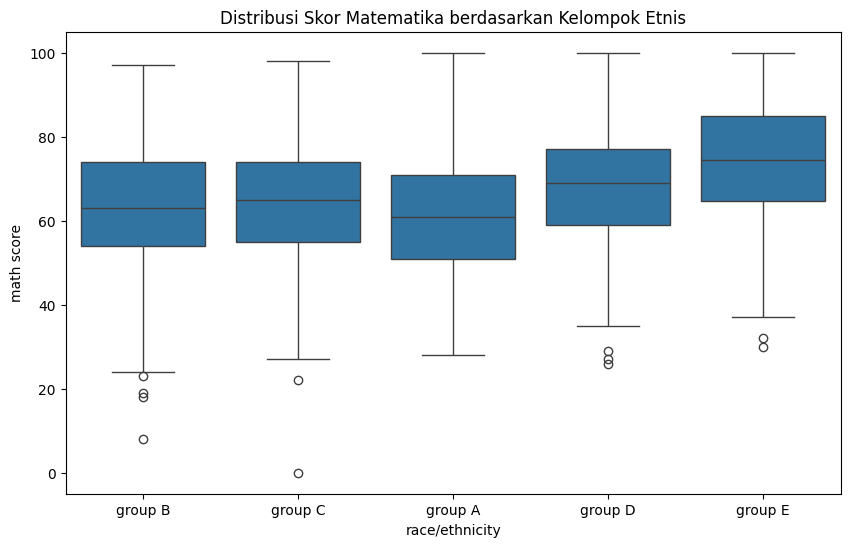


Analysis 3: Parental Education Influence

associate's degree:
  Rata-rata skor Matematika: 67.88

bachelor's degree:
  Rata-rata skor Matematika: 69.39

high school:
  Rata-rata skor Matematika: 62.14

master's degree:
  Rata-rata skor Matematika: 69.75

some college:
  Rata-rata skor Matematika: 67.13

some high school:
  Rata-rata skor Matematika: 63.50

ANOVA Test (Math Score):
  F-statistic: 6.52
  p-value: 0.000
  Terdapat perbedaan signifikan dalam skor matematika berdasarkan tingkat pendidikan orang tua.


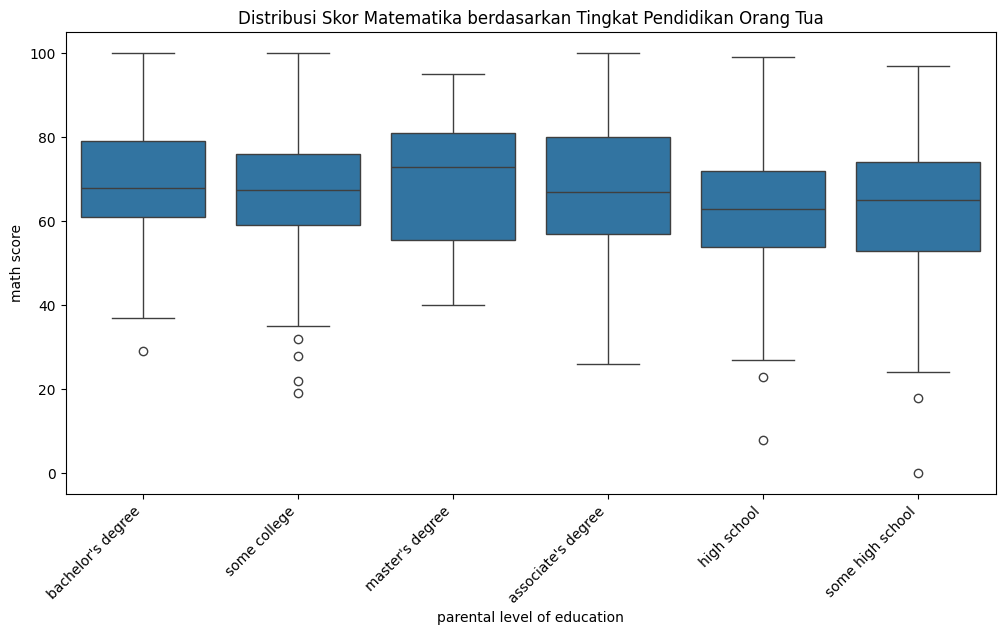

In [61]:
# Analysis 1: Gender Differences
print("\nAnalysis 1: Gender Differences")
female_scores = df_encoded[df_encoded['gender'] == 0]
male_scores = df_encoded[df_encoded['gender'] == 1]


def analyze_gender_differences(subject):
    t_stat, p_val = ttest_ind(female_scores[subject], male_scores[subject])
    print(f"\n{subject.replace('_', ' ').title()}:")
    print(f"  t-statistic: {t_stat:.2f}")
    print(f"  p-value: {p_val:.3f}")
    if p_val < 0.05:
        print(f"  Terdapat perbedaan signifikan dalam {subject} berdasarkan jenis kelamin.")
    else:
        print(f"  Tidak terdapat perbedaan signifikan dalam {subject} berdasarkan jenis kelamin.")

analyze_gender_differences("math score")
analyze_gender_differences("reading score")
analyze_gender_differences("writing score")

# Analysis 2: Ethnicity Impact
print("\nAnalysis 2: Ethnicity Impact")
ethnicity_groups = df.groupby('race/ethnicity')
for name, group in ethnicity_groups:
    print(f"\n{name}:")
    print(f"  Rata-rata skor Matematika: {group['math score'].mean():.2f}")

f_stat, p_val = f_oneway(*[group["math score"].values for name, group in ethnicity_groups])
print(f"\nANOVA Test (Math Score):")
print(f"  F-statistic: {f_stat:.2f}")
print(f"  p-value: {p_val:.3f}")
if p_val < 0.05:
  print("  Terdapat perbedaan signifikan dalam skor matematika berdasarkan etnis.")
else:
  print("  Tidak terdapat perbedaan signifikan dalam skor matematika berdasarkan etnis.")

#Visualisasi skor matematika berdasarkan kelompok etnis
plt.figure(figsize=(10, 6))
sns.boxplot(x='race/ethnicity', y='math score', data=df)
plt.title('Distribusi Skor Matematika berdasarkan Kelompok Etnis')
plt.show()

# Analysis 3: Parental Education Influence
print("\nAnalysis 3: Parental Education Influence")
# Use the original df for grouping by 'parental level of education'
parental_education_groups = df.groupby('parental level of education')
for name, group in parental_education_groups:
    print(f"\n{name}:")
    print(f"  Rata-rata skor Matematika: {group['math score'].mean():.2f}")

f_stat, p_val = f_oneway(*[group["math score"].values for name, group in parental_education_groups])
print(f"\nANOVA Test (Math Score):")
print(f"  F-statistic: {f_stat:.2f}")
print(f"  p-value: {p_val:.3f}")
if p_val < 0.05:
  print("  Terdapat perbedaan signifikan dalam skor matematika berdasarkan tingkat pendidikan orang tua.")
else:
  print("  Tidak terdapat perbedaan signifikan dalam skor matematika berdasarkan tingkat pendidikan orang tua.")

# Visualisasi skor matematika berdasarkan tingkat pendidikan orang tua
plt.figure(figsize=(12, 6))
sns.boxplot(x='parental level of education', y='math score', data=df)
plt.title('Distribusi Skor Matematika berdasarkan Tingkat Pendidikan Orang Tua')
plt.xticks(rotation=45, ha='right')
plt.show()

#### insight:

Analisis data eksploratif (EDA) menunjukkan pola-pola awal pada data siswa.  Pembersihan data meliputi penanganan nilai hilang dengan imputasi mean untuk variabel numerik dan penghapusan data duplikat.  Selanjutnya, persiapan data melibatkan transformasi variabel kategorikal (jenis kelamin, kursus persiapan ujian, jenis makan siang, ras/etnis, dan tingkat pendidikan orang tua) menjadi representasi numerik menggunakan label encoding dan one-hot encoding.  Analisis awal mengungkap perbedaan signifikan skor matematika, membaca, dan menulis berdasarkan jenis kelamin, serta pengaruh tingkat pendidikan orang tua dan kelompok etnis terhadap skor matematika siswa, yang dikonfirmasi melalui uji statistik (t-test dan ANOVA).


```
# This is formatted as code
```



## Modeling


In [62]:
# Modeling
# Model linear reggresion
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# Model decision tree
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)


#### insight:
- Proses modeling yang telah dilakukan menunjukkan penerapan dua algoritma regresi, yaitu Regresi Linear dan Decision Tree Regressor, untuk memprediksi nilai matematika siswa.  Penggunaan kedua algoritma ini memungkinkan perbandingan performa masing-masing model dalam memprediksi nilai matematika.  Meskipun kode hanya menampilkan inisiasi dan pelatihan model,  langkah evaluasi model yang  dilakukan  nantinya  sangat krusial  untuk menentukan model mana yang lebih baik.  Evaluasi dapat menggunakan metrik seperti *Mean Absolute Error*, *Mean Squared Error*, dan *R-squared* untuk mengukur akurasi dan ketepatan prediksi model. Pemilihan *random state* pada Decision Tree Regressor  memungkinkan hasil pelatihan model menjadi dapat direplikasi.  Secara keseluruhan, proses ini memberikan gambaran awal tentang bagaimana model regresi dapat digunakan untuk memprediksi nilai matematika, dengan potensi untuk ditingkatkan melalui proses evaluasi dan optimasi model yang lebih komprehensif.


# Evaluasi Model

In [57]:
# Evaluasi model regresi linear
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print("Evaluasi Model Regresi Linear:")
print(f"MAE: {mae_linear}")
print(f"MSE: {mse_linear}")
print(f"RMSE: {rmse_linear}")
print(f"R-squared: {r2_linear}")

# Evaluasi model decision tree
mae_tree = mean_absolute_error(y_test, y_pred_tree)
mse_tree = mean_squared_error(y_test, y_pred_tree)
rmse_tree = np.sqrt(mse_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print("\nEvaluasi Model Decision Tree:")
print(f"MAE: {mae_tree}")
print(f"MSE: {mse_tree}")
print(f"RMSE: {rmse_tree}")
print(f"R-squared: {r2_tree}")
print("\nKesimpulan:")

if r2_linear > r2_tree:
    print("Model Regresi Linear lebih baik daripada Decision Tree berdasarkan R-squared.")
    print(f"Model Regresi Linear mampu menjelaskan {r2_linear*100:.2f}% variabilitas data.")
else:
    print("Model Decision Tree lebih baik daripada Regresi Linear berdasarkan R-squared.")
    print(f"Model Decision Tree mampu menjelaskan {r2_tree*100:.2f}% variabilitas data.")



Evaluasi Model Regresi Linear:
MAE: 4.214763142474852
MSE: 29.0951698667155
RMSE: 5.393993869732844
R-squared: 0.8804332983749564

Evaluasi Model Decision Tree:
MAE: 6.56
MSE: 67.71
RMSE: 8.228608630868283
R-squared: 0.7217455198193133

Kesimpulan:
Model Regresi Linear lebih baik daripada Decision Tree berdasarkan R-squared.
Model Regresi Linear mampu menjelaskan 88.04% variabilitas data.


#### insight:
- Proses evaluasi model yang dilakukan memberikan beberapa *insight* penting.  Pertama, penggunaan metrik evaluasi seperti MAE, MSE, RMSE, dan R-squared memungkinkan perbandingan kinerja antara model Regresi Linear dan Decision Tree.  Nilai MAE menunjukkan rata-rata selisih absolut antara prediksi dan nilai sebenarnya, sedangkan MSE dan RMSE mengukur rata-rata kuadrat selisih tersebut, dengan RMSE memberikan interpretasi dalam satuan yang sama dengan variabel target.  R-squared menunjukkan proporsi variabilitas data yang dijelaskan oleh model.  Dengan membandingkan nilai-nilai metrik ini untuk kedua model, kita dapat menentukan model mana yang lebih akurat dan tepat dalam memprediksi nilai matematika siswa.  Kedua, analisis lebih lanjut terhadap nilai-nilai metrik tersebut dapat memberikan petunjuk mengenai kelebihan dan kekurangan masing-masing model. Misalnya, jika Decision Tree memiliki RMSE yang lebih rendah tetapi R-squared yang lebih rendah dibandingkan dengan model Regresi Linear, hal tersebut mengindikasikan bahwa Decision Tree mungkin lebih baik dalam  memprediksi nilai sebenarnya, tetapi kemampuannya dalam menjelaskan keseluruhan variasi data mungkin lebih rendah. Kesimpulannya, proses evaluasi ini tidak hanya mengukur kinerja model, tetapi juga menyediakan dasar untuk memilih model terbaik dan memahami karakteristik prediksinya.


## Visualisasi Model

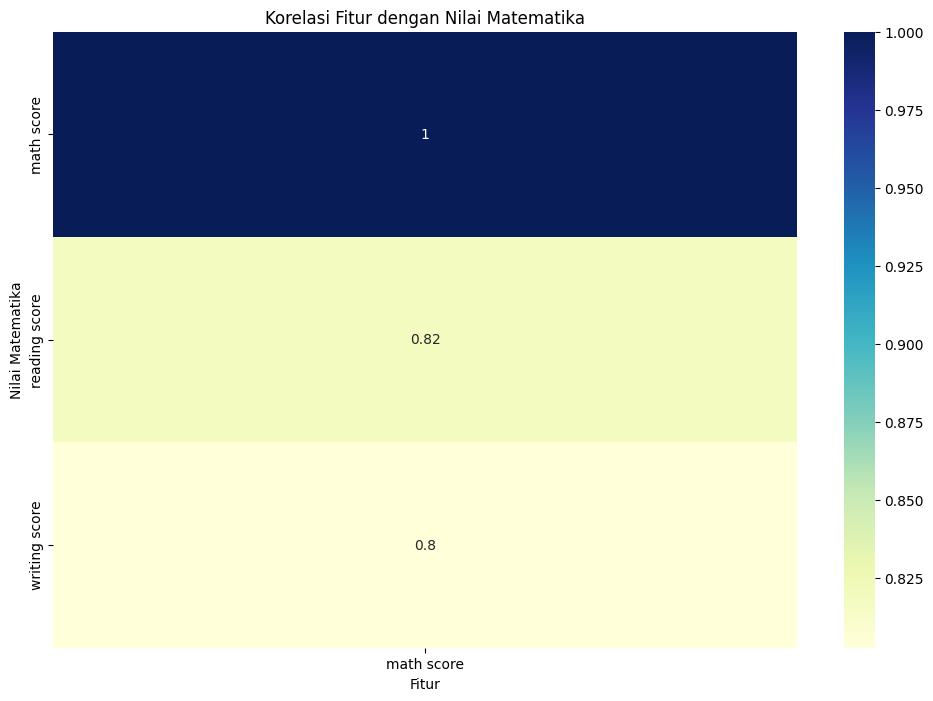

In [59]:
# Korelasi dengan nilai akhir
plt.figure(figsize=(12, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr[['math score']].sort_values(by='math score', ascending=False), annot=True, cmap='YlGnBu')
plt.title("Korelasi Fitur dengan Nilai Matematika")
plt.xlabel("Fitur")
plt.ylabel("Nilai Matematika")
plt.show()

#### insight:
- Visualisasi model melalui *heatmap* korelasi memberikan pemahaman tentang hubungan antara setiap fitur dengan nilai matematika siswa.  Dari peta panas tersebut, dapat diidentifikasi fitur-fitur yang memiliki korelasi kuat, sedang, atau lemah dengan nilai matematika. Fitur dengan korelasi positif yang tinggi menunjukkan bahwa peningkatan nilai fitur tersebut cenderung diiringi dengan peningkatan nilai matematika, dan sebaliknya untuk korelasi negatif.  Informasi ini bermanfaat untuk memahami faktor-faktor yang paling berpengaruh terhadap prestasi belajar siswa dalam matematika.  Selain itu, visualisasi ini juga membantu dalam menyeleksi fitur yang relevan untuk model prediksi, sehingga model yang dihasilkan dapat lebih akurat dan efisien.  Dengan demikian, visualisasi model ini bukan hanya sekadar representasi grafis, tetapi juga alat analitis yang penting dalam proses *machine learning*.

